## Saving Pi-Control TAGGED Xarray in .nc



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

##Save .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
model     = 'iCESM'

exp = 'CTRL'

XCHUNK = 144 #Full size chunk seems to make things run quickest
YCHUNK = 96 #Full Y size chunk makes things run quickest
ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 912  #Run-time seems consistent with changes to TCHUNK, but 12 looks like best and logical

VARS_USED = ["LANDFRAC", "TS", "PSL", "V", "U", "PRECC", "PRECL", "TREFHT", "ICEFRAC", "PRECSL_H218OS", "PRECSC_H218Os", "PRECRL_H218OR", "PRECRC_H218Or", "PRECSL_H2OS", "PRECSC_H2Os", "PRECRL_H2OR", "PRECRC_H2Or",
             "PRECSC_At0518_s", "PRECSC_At05_s", "PRECSL_At0518_S", "PRECSL_At05_S", "PRECRC_At0518_r", "PRECRC_At05_r", "PRECRL_At0518_R", "PRECRL_At05_R",
             "PRECSC_At1518_s", "PRECSC_At15_s", "PRECSL_At1518_S", "PRECSL_At15_S", "PRECRC_At1518_r", "PRECRC_At15_r", "PRECRL_At1518_R", "PRECRL_At15_R",
             "PRECSC_At2518_s", "PRECSC_At25_s", "PRECSL_At2518_S", "PRECSL_At25_S", "PRECRC_At2518_r", "PRECRC_At25_r", "PRECRL_At2518_R", "PRECRL_At25_R",
             "PRECSC_At3518_s", "PRECSC_At35_s", "PRECSL_At3518_S", "PRECSL_At35_S", "PRECRC_At3518_r", "PRECRC_At35_r", "PRECRL_At3518_R", "PRECRL_At35_R",
             "PRECSC_At4518_s", "PRECSC_At45_s", "PRECSL_At4518_S", "PRECSL_At45_S", "PRECRC_At4518_r", "PRECRC_At45_r", "PRECRL_At4518_R", "PRECRL_At45_R",
             "PRECSC_At5518_s", "PRECSC_At55_s", "PRECSL_At5518_S", "PRECSL_At55_S", "PRECRC_At5518_r", "PRECRC_At55_r", "PRECRL_At5518_R", "PRECRL_At55_R",
             "PRECSC_At6518_s", "PRECSC_At65_s", "PRECSL_At6518_S", "PRECSL_At65_S", "PRECRC_At6518_r", "PRECRC_At65_r", "PRECRL_At6518_R", "PRECRL_At65_R",
             "PRECSC_At7518_s", "PRECSC_At75_s", "PRECSL_At7518_S", "PRECSL_At75_S", "PRECRC_At7518_r", "PRECRC_At75_r", "PRECRL_At7518_R", "PRECRL_At75_R",
             "PRECSC_Pa0518_s", "PRECSC_Pa05_s", "PRECSL_Pa0518_S", "PRECSL_Pa05_S", "PRECRC_Pa0518_r", "PRECRC_Pa05_r", "PRECRL_Pa0518_R", "PRECRL_Pa05_R",
             "PRECSC_Pa1518_s", "PRECSC_Pa15_s", "PRECSL_Pa1518_S", "PRECSL_Pa15_S", "PRECRC_Pa1518_r", "PRECRC_Pa15_r", "PRECRL_Pa1518_R", "PRECRL_Pa15_R",
             "PRECSC_Pa2518_s", "PRECSC_Pa25_s", "PRECSL_Pa2518_S", "PRECSL_Pa25_S", "PRECRC_Pa2518_r", "PRECRC_Pa25_r", "PRECRL_Pa2518_R", "PRECRL_Pa25_R",
             "PRECSC_Pa3518_s", "PRECSC_Pa35_s", "PRECSL_Pa3518_S", "PRECSL_Pa35_S", "PRECRC_Pa3518_r", "PRECRC_Pa35_r", "PRECRL_Pa3518_R", "PRECRL_Pa35_R",
             "PRECSC_Pa4518_s", "PRECSC_Pa45_s", "PRECSL_Pa4518_S", "PRECSL_Pa45_S", "PRECRC_Pa4518_r", "PRECRC_Pa45_r", "PRECRL_Pa4518_R", "PRECRL_Pa45_R",
             "PRECSC_Pa5518_s", "PRECSC_Pa55_s", "PRECSL_Pa5518_S", "PRECSL_Pa55_S", "PRECRC_Pa5518_r", "PRECRC_Pa55_r", "PRECRL_Pa5518_R", "PRECRL_Pa55_R",
             "PRECSC_Pa6518_s", "PRECSC_Pa65_s", "PRECSL_Pa6518_S", "PRECSL_Pa65_S", "PRECRC_Pa6518_r", "PRECRC_Pa65_r", "PRECRL_Pa6518_R", "PRECRL_Pa65_R",
             "PRECSC_Pa7518_s", "PRECSC_Pa75_s", "PRECSL_Pa7518_S", "PRECSL_Pa75_S", "PRECRC_Pa7518_r", "PRECRC_Pa75_r", "PRECRL_Pa7518_R", "PRECRL_Pa75_R",             
             "PRECSC_In0518_s", "PRECSC_In05_s", "PRECSL_In0518_S", "PRECSL_In05_S", "PRECRC_In0518_r", "PRECRC_In05_r", "PRECRL_In0518_R", "PRECRL_In05_R",
             "PRECSC_In1518_s", "PRECSC_In15_s", "PRECSL_In1518_S", "PRECSL_In15_S", "PRECRC_In1518_r", "PRECRC_In15_r", "PRECRL_In1518_R", "PRECRL_In15_R",
             "PRECSC_In2518_s", "PRECSC_In25_s", "PRECSL_In2518_S", "PRECSL_In25_S", "PRECRC_In2518_r", "PRECRC_In25_r", "PRECRL_In2518_R", "PRECRL_In25_R",
             "PRECSC_In3518_s", "PRECSC_In35_s", "PRECSL_In3518_S", "PRECSL_In35_S", "PRECRC_In3518_r", "PRECRC_In35_r", "PRECRL_In3518_R", "PRECRL_In35_R",
             "PRECSC_In4518_s", "PRECSC_In45_s", "PRECSL_In4518_S", "PRECSL_In45_S", "PRECRC_In4518_r", "PRECRC_In45_r", "PRECRL_In4518_R", "PRECRL_In45_R",
             "PRECSC_In5518_s", "PRECSC_In55_s", "PRECSL_In5518_S", "PRECSL_In55_S", "PRECRC_In5518_r", "PRECRC_In55_r", "PRECRL_In5518_R", "PRECRL_In55_R",
             "PRECSC_In6518_s", "PRECSC_In65_s", "PRECSL_In6518_S", "PRECSL_In65_S", "PRECRC_In6518_r", "PRECRC_In65_r", "PRECRL_In6518_R", "PRECRL_In65_R",
             "PRECSC_In7518_s", "PRECSC_In75_s", "PRECSL_In7518_S", "PRECSL_In75_S", "PRECRC_In7518_r", "PRECRC_In75_r", "PRECRL_In7518_R", "PRECRL_In75_R",       
             "PRECSC_AAie18_s", "PRECSC_AAice_s", "PRECSL_AAie18_S", "PRECSL_AAice_S", "PRECRC_AAie18_r", "PRECRC_AAice_r", "PRECRL_AAie18_R", "PRECRL_AAice_R",
             "PRECSC_AAld18_s", "PRECSC_AAlnd_s", "PRECSL_AAld18_S", "PRECSL_AAlnd_S", "PRECRC_AAld18_r", "PRECRC_AAlnd_r", "PRECRL_AAld18_R", "PRECRL_AAlnd_R"
            ]



#PATH TO CTRL DATA WITH TAGGING
# CTRL_DATA_PATH = '/gpfs/fs1/scratch/crtabor/archive/b.ie12.BG1850C5CN.f19_g16.0ka_0urb.001_ALL_d18O_2/atm/hist/b.ie12.BG1850C5CN.f19_g16.0ka_0urb.001_ALL_d18O_2.cam.h0.00??-??.nc'
CTRL_DATA_PATH = '/gpfs/fs1/p/cesm/palwg_dev/cretaceous/archive/b.ie12.BG1850C5CN.f19_g16.0ka_0urb.001_ALL_d18O_2/atm/hist/b.ie12.BG1850C5CN.f19_g16.0ka_0urb.001_ALL_d18O_2.cam.h0.00??-??.nc'

In [4]:
#use xarray to open multiple netCDF files as dask arrays:
#about 14 sec for each 12 months, or around 12 min for 48 years
#decode_cf needs to be set to True for proper concatenation on T axis
CTRL_DATA_RAW = xr.open_mfdataset(CTRL_DATA_PATH, decode_cf=False, chunks={'lon':XCHUNK,'lat':YCHUNK, 'lev':ZCHUNK})[VARS_USED]
CTRL_DATA_RAW = CTRL_DATA_RAW.chunk({'time':TCHUNK}) 

print(CTRL_DATA_RAW)

<xarray.Dataset>
Dimensions:          (lat: 96, lev: 30, lon: 144, time: 912)
Coordinates:
  * time             (time) float64 31.0 59.0 90.0 ... 2.771e+04 2.774e+04
  * lat              (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lev              (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon              (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    LANDFRAC         (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    TS               (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    PSL              (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    V                (time, lev, lat, lon) float32 dask.array<shape=(912, 30, 96, 144), chunksize=(912, 30, 96, 144)>
    U                (time, lev, lat, lon) float32 dask.array<shape=(912, 30, 96, 144), chunksize=(912, 30, 96, 144)>
    PRECC            (time, lat

In [51]:
# aa = (CTRL_DATA_RAW.PRECRC_Pa65_r + CTRL_DATA_RAW.PRECRL_Pa65_R + CTRL_DATA_RAW.PRECSC_Pa65_s + CTRL_DATA_RAW.PRECSL_Pa65_S)
# aa1 = (CTRL_DATA_RAW.PRECRC_Pa6518_r + CTRL_DATA_RAW.PRECRL_Pa6518_R + CTRL_DATA_RAW.PRECSC_Pa6518_s + CTRL_DATA_RAW.PRECSL_Pa6518_S)
# bb = (CTRL_DATA_RAW.PRECRC_At05_r + CTRL_DATA_RAW.PRECRL_At05_R + CTRL_DATA_RAW.PRECSC_At05_s + CTRL_DATA_RAW.PRECSL_At05_S)
# bb1 = (CTRL_DATA_RAW.PRECRC_At0518_r + CTRL_DATA_RAW.PRECRL_At0518_R + CTRL_DATA_RAW.PRECSC_At0518_s + CTRL_DATA_RAW.PRECSL_At0518_S)
# cc = (CTRL_DATA_RAW.PRECC + CTRL_DATA_RAW.PRECL)
# dd = (CTRL_DATA_RAW.PRECRC_H2Or + CTRL_DATA_RAW.PRECRL_H2OR + CTRL_DATA_RAW.PRECSC_H2Os + CTRL_DATA_RAW.PRECSL_H2OS)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


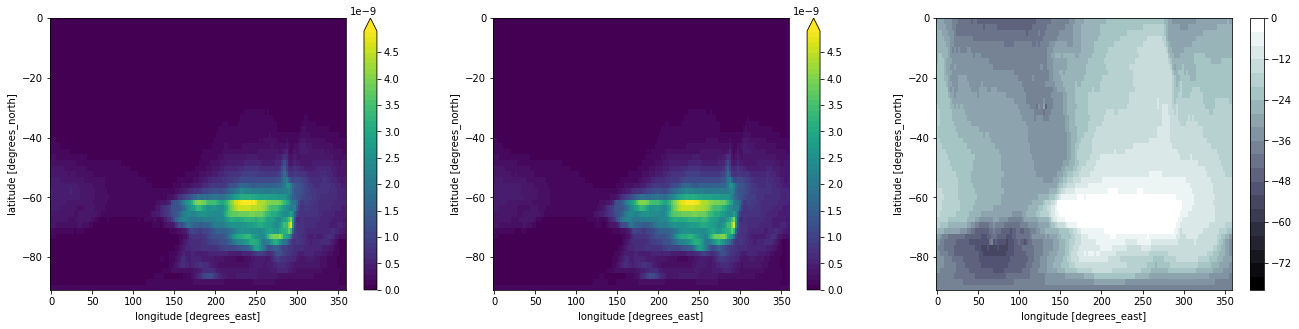

In [68]:
# plt.figure(figsize=(22.5,5))
# plt.subplot(1,3,1)
# aa.sel(lat=slice(-90, 0)).mean(axis=0).plot(levels=np.arange(0,5e-09,1e-10))
# plt.subplot(1,3,2)
# aa1.sel(lat=slice(-90, 0)).mean(axis=0).plot(levels=np.arange(0,5e-09,1e-10))
# aa2 = ((aa1/aa)-1)*1000
# plt.subplot(1,3,3)
# aa2.sel(lat=slice(-90, 0)).mean(axis=0).plot(levels=np.arange(-80,4,4),cmap=plt.cm.get_cmap('bone'))

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


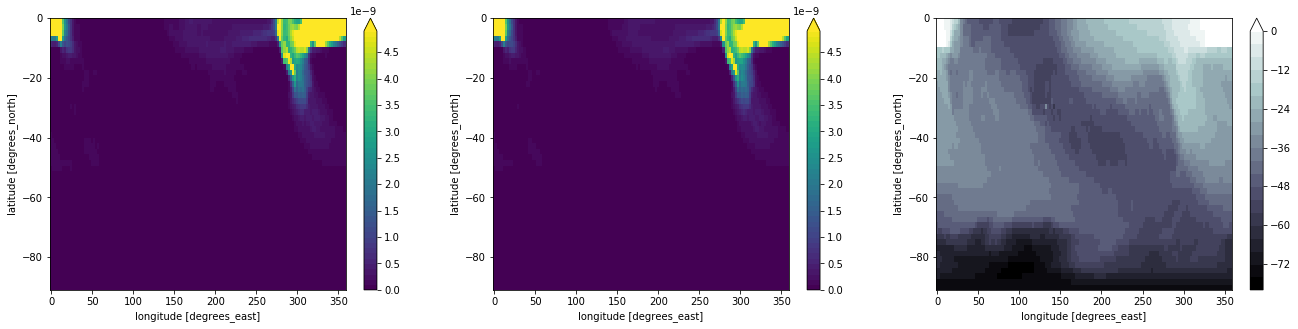

In [69]:
# plt.figure(figsize=(22.5,5))
# plt.subplot(1,3,1)
# bb.sel(lat=slice(-90, 0)).mean(axis=0).plot(levels=np.arange(0,5e-09,1e-10))
# plt.subplot(1,3,2)
# bb1.sel(lat=slice(-90, 0)).mean(axis=0).plot(levels=np.arange(0,5e-09,1e-10))
# bb2 = ((bb1/bb)-1)*1000
# plt.subplot(1,3,3)
# bb2.sel(lat=slice(-90, 0)).mean(axis=0).plot(levels=np.arange(-80,4,4),cmap=plt.cm.get_cmap('bone'))

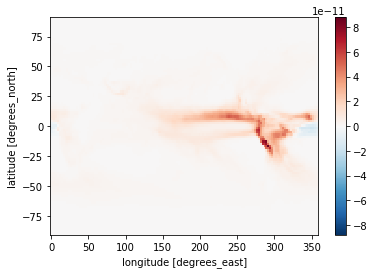

In [53]:
# (bb - bb1).mean(axis=0).plot()

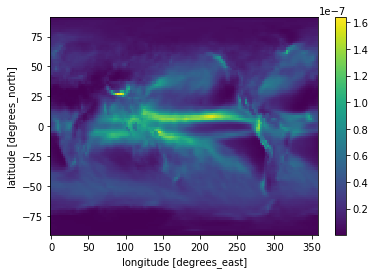

In [36]:
# cc.mean(axis=0).plot()

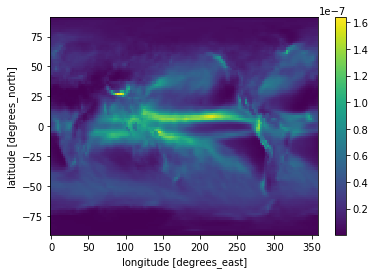

In [37]:
# dd.mean(axis=0).plot()

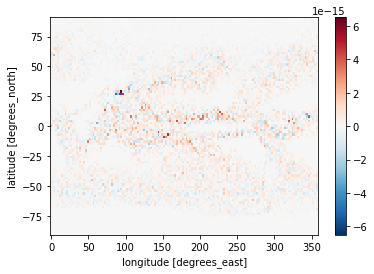

In [38]:
# ee = cc - dd
# ee.mean(axis=0).plot()

In [82]:
#Creating DataArrays for each variable with the time changed to datetime months
#NOTE, DATETIME DOESN'T DO DATES BEFORE 1648, SO TREATING 1702 AS 0002 IN CESM DATA!!!!!!!!!!

time_new = pd.date_range(start='1701-01-01', end='1776-12-31', freq='M')
# time_new = pd.date_range(start='1770-01-01', end='1770-12-31', freq='M')

sst_da = xr.DataArray(CTRL_DATA_RAW.data_vars['TS'].where(CTRL_DATA_RAW.data_vars['LANDFRAC'][0,:,:] < 0.50), coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'], 'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
msl_da = xr.DataArray(CTRL_DATA_RAW.data_vars['PSL'], coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
u10_da = xr.DataArray(CTRL_DATA_RAW.data_vars['U'][:,29,:,:], coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
v10_da = xr.DataArray(CTRL_DATA_RAW.data_vars['V'][:,29,:,:], coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
t2m_da = xr.DataArray(CTRL_DATA_RAW.data_vars['TREFHT'], coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECC']+ CTRL_DATA_RAW.data_vars['PRECL']), coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
ci_da = xr.DataArray(CTRL_DATA_RAW.data_vars['ICEFRAC'], coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_H218OS'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_H218Os'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_H218OR'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_H218Or'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_H2OS'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_H2Os'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_H2OR'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_H2Or'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))

d18O_Atl_05_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At0518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At0518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At0518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At0518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At05_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At05_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At05_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At05_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_15_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At1518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At1518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At1518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At1518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At15_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At15_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At15_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At15_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_25_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At2518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At2518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At2518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At2518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At25_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At25_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At25_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At25_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_35_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At3518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At3518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At3518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At3518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At35_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At35_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At35_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At35_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_45_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At4518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At4518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At4518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At4518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At45_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At45_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At45_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At45_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_55_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At5518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At5518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At5518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At5518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At55_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At55_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At55_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At55_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_65_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At6518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At6518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At6518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At6518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At65_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At65_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At65_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At65_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Atl_75_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_At7518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At7518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At7518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At7518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_At75_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At75_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At75_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At75_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_05_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At05_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At05_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At05_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At05_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_15_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At15_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At15_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At15_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At15_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_25_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At25_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At25_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At25_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At25_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_35_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At35_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At35_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At35_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At35_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_45_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At45_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At45_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At45_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At45_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_55_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At55_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At55_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At55_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At55_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_65_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At65_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At65_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At65_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At65_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Atl_75_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_At75_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_At75_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_At75_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_At75_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))

d18O_Pac_05_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa0518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa0518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa0518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa0518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa05_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa05_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa05_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa05_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_15_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa1518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa1518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa1518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa1518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa15_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa15_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa15_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa15_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_25_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa2518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa2518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa2518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa2518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa25_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa25_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa25_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa25_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_35_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa3518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa3518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa3518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa3518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa35_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa35_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa35_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa35_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_45_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa4518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa4518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa4518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa4518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa45_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa45_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa45_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa45_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_55_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa5518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa5518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa5518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa5518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa55_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa55_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa55_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa55_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_65_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa6518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa6518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa6518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa6518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa65_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa65_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa65_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa65_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Pac_75_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_Pa7518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa7518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa7518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa7518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_Pa75_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa75_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa75_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa75_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_05_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa05_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa05_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa05_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa05_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_15_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa15_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa15_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa15_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa15_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_25_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa25_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa25_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa25_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa25_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_35_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa35_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa35_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa35_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa35_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_45_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa45_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa45_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa45_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa45_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_55_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa55_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa55_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa55_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa55_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_65_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa65_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa65_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa65_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa65_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Pac_75_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_Pa75_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_Pa75_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_Pa75_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_Pa75_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))

d18O_Ind_05_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In0518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In0518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In0518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In0518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In05_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In05_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In05_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In05_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_15_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In1518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In1518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In1518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In1518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In15_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In15_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In15_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In15_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_25_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In2518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In2518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In2518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In2518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In25_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In25_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In25_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In25_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_35_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In3518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In3518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In3518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In3518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In35_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In35_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In35_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In35_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_45_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In4518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In4518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In4518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In4518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In45_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In45_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In45_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In45_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_55_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In5518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In5518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In5518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In5518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In55_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In55_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In55_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In55_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_65_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In6518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In6518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In6518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In6518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In65_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In65_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In65_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In65_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
d18O_Ind_75_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_In7518_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In7518_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In7518_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In7518_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_In75_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In75_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In75_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In75_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_05_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In05_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In05_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In05_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In05_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_15_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In15_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In15_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In15_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In15_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_25_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In25_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In25_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In25_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In25_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_35_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In35_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In35_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In35_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In35_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_45_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In45_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In45_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In45_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In45_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_55_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In55_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In55_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In55_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In55_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_65_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In65_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In65_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In65_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In65_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_Ind_75_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_In75_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_In75_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_In75_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_In75_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))

d18O_AA_ice_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_AAie18_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_AAie18_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_AAie18_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_AAie18_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_AAice_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_AAice_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_AAice_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_AAice_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_AA_ice_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_AAice_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_AAice_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_AAice_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_AAice_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))

d18O_AA_land_da = xr.DataArray((((CTRL_DATA_RAW.data_vars['PRECSL_AAld18_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_AAld18_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_AAld18_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_AAld18_r'][:,:,:])/
                       (CTRL_DATA_RAW.data_vars['PRECSL_AAlnd_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_AAlnd_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_AAlnd_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_AAlnd_r'][:,:,:]))-1)*1000
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))
tp_AA_land_da = xr.DataArray((CTRL_DATA_RAW.data_vars['PRECSL_AAlnd_S'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECSC_AAlnd_s'][:,:,:]+
                       CTRL_DATA_RAW.data_vars['PRECRL_AAlnd_R'][:,:,:]+CTRL_DATA_RAW.data_vars['PRECRC_AAlnd_r'][:,:,:])
                       , coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))

land_da = xr.DataArray(CTRL_DATA_RAW.data_vars['LANDFRAC'], coords={'time': time_new, 'lat': CTRL_DATA_RAW.coords['lat'],'lon': CTRL_DATA_RAW.coords['lon']}, dims=('time','lat','lon'))


#Creating Dataset with adjusted time coordinate
CTRL_DATA = xr.Dataset({'land_frac': land_da, 'sst': sst_da, 'msl': msl_da, 'u10': u10_da, 'v10': v10_da, 't2m': t2m_da, 'tp': tp_da, 'ci': ci_da, 'd18O': d18O_da, 
                        'd18O_Atl_05': d18O_Atl_05_da, 'd18O_Atl_15': d18O_Atl_15_da, 'd18O_Atl_25': d18O_Atl_25_da, 'd18O_Atl_35': d18O_Atl_35_da, 'd18O_Atl_45': d18O_Atl_45_da, 'd18O_Atl_55': d18O_Atl_55_da, 'd18O_Atl_65': d18O_Atl_65_da, 'd18O_Atl_75': d18O_Atl_75_da,
                        'tp_Atl_05': tp_Atl_05_da, 'tp_Atl_15': tp_Atl_15_da, 'tp_Atl_25': tp_Atl_25_da, 'tp_Atl_35': tp_Atl_35_da, 'tp_Atl_45': tp_Atl_45_da, 'tp_Atl_55': tp_Atl_55_da, 'tp_Atl_65': tp_Atl_65_da, 'tp_Atl_75': tp_Atl_75_da,
                        'd18O_Pac_05': d18O_Pac_05_da, 'd18O_Pac_15': d18O_Pac_15_da, 'd18O_Pac_25': d18O_Pac_25_da, 'd18O_Pac_35': d18O_Pac_35_da, 'd18O_Pac_45': d18O_Pac_45_da, 'd18O_Pac_55': d18O_Pac_55_da, 'd18O_Pac_65': d18O_Pac_65_da, 'd18O_Pac_75': d18O_Pac_75_da,
                        'tp_Pac_05': tp_Pac_05_da, 'tp_Pac_15': tp_Pac_15_da, 'tp_Pac_25': tp_Pac_25_da, 'tp_Pac_35': tp_Pac_35_da, 'tp_Pac_45': tp_Pac_45_da, 'tp_Pac_55': tp_Pac_55_da, 'tp_Pac_65': tp_Pac_65_da, 'tp_Pac_75': tp_Pac_75_da,
                        'd18O_Ind_05': d18O_Ind_05_da, 'd18O_Ind_15': d18O_Ind_15_da, 'd18O_Ind_25': d18O_Ind_25_da, 'd18O_Ind_35': d18O_Ind_35_da, 'd18O_Ind_45': d18O_Ind_45_da, 'd18O_Ind_55': d18O_Ind_55_da, 'd18O_Ind_65': d18O_Ind_65_da, 'd18O_Ind_75': d18O_Ind_75_da,
                        'tp_Ind_05': tp_Ind_05_da, 'tp_Ind_15': tp_Ind_15_da, 'tp_Ind_25': tp_Ind_25_da, 'tp_Ind_35': tp_Ind_35_da, 'tp_Ind_45': tp_Ind_45_da, 'tp_Ind_55': tp_Ind_55_da, 'tp_Ind_65': tp_Ind_65_da, 'tp_Ind_75': tp_Ind_75_da,
                        'd18O_AA_ice': d18O_AA_ice_da, 'd18O_AA_land': d18O_AA_land_da,
                        'tp_AA_ice': tp_AA_ice_da, 'tp_AA_land': tp_AA_land_da
                       })
CTRL_DATA = CTRL_DATA.chunk(chunks={'lon':XCHUNK,'lat':YCHUNK})
CTRL_DATA = CTRL_DATA.chunk({'time':TCHUNK})

CTRL_DATA




/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 1701-03-31 ...
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 ...
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 ...
Data variables:
    land_frac     (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    sst           (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    msl           (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    u10           (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    v10           (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    t2m           (time, lat, lon) float32 dask.array<shape=(912, 96, 144), chunksize=(912, 96, 144)>
    tp            (time, lat, lon) float32 dask.array<shape=(9

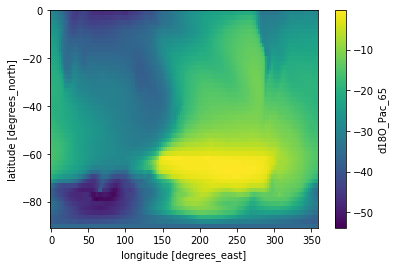

In [86]:
CTRL_DATA.d18O_Pac_65.sel(lat=slice(-90, 0)).mean(axis=0).plot()

## Calculate/interpret the tagged results, specifically for using them to estimate how much of the d18O signal at the WDC location comes from each latitudinal band for each month.


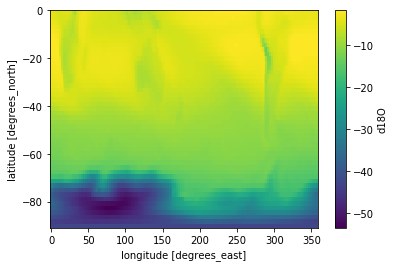

In [84]:
CTRL_DATA.d18O.sel(lat=slice(-90, 0)).mean(axis=0).plot()

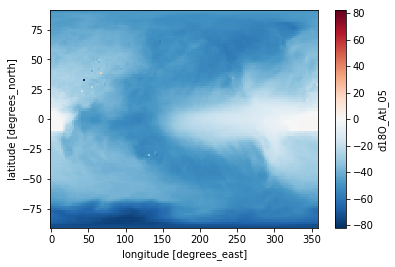

In [25]:
CTRL_DATA.d18O_Atl_05.sel(lat=slice(-90, 90)).mean(axis=0).plot()

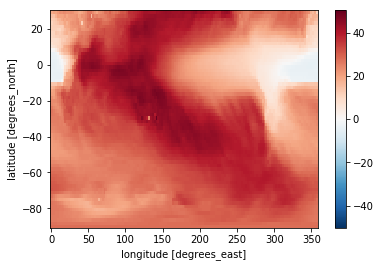

In [24]:
aa = (CTRL_DATA.d18O.sel(lat=slice(-90, 30)).mean(axis=0)) - (CTRL_DATA.d18O_Atl_05.sel(lat=slice(-90, 30)).mean(axis=0))
aa.plot()

In [87]:
# SAVE as a NetCDF file
CTRL_DATA.to_netcdf(NETCDF_PATH+'/CTRL_DATA_TAGGED.nc')

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [5]:
ds_disk = xr.open_dataset(NETCDF_PATH+'/CTRL_DATA_TAGGED.nc')
ds_disk

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 1701-03-31 ...
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 ...
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 ...
Data variables:
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    tp            (time, lat, lon) float32 ...
    ci            (time, lat, lon) float32 ...
    d18O          (time, lat, lon) float32 ...
    d18O_Atl_05   (time, lat, lon) float32 ...
    d18O_Atl_15   (time, lat, lon) float32 ...
    d18O_Atl_25   (time, lat, lon) float32 ...
    d18O_Atl_35   (time, lat, lon) float32 ...
    d18O_Atl_45   (time, lat, lon) float32 ...
    d18O_Atl_55 

In [ ]:
#Need to put this into each Notebook
#getting variables in right units 

In [ ]:
# slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
# v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
# u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
# t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
# tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
# ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
# sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
# d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
# land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

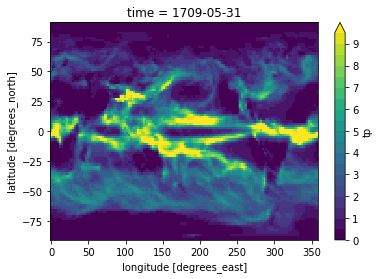

In [12]:
aa = ds_disk.tp*60*60*24*1000 
aa[100].plot(levels=np.arange(0,10,.5))

In [ ]:
a